In [45]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
random.seed(0)
np.random.seed(0)

In [46]:
data_path = "../data/raw/android_traffic.csv"
data = pd.read_csv(data_path)

le = LabelEncoder()
data_x, data_y = data.drop(columns=['type']).values, le.fit_transform(data['type'])
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2)

data.head()


,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
0,36,6,3,3911,0,39,33,5100,4140,39,3,benign
1,117,0,9,23514,0,128,107,26248,24358,128,11,benign
2,196,0,6,24151,0,205,214,163887,24867,205,9,benign
3,6,0,1,889,0,7,6,819,975,7,1,benign
4,6,0,1,882,0,7,6,819,968,7,1,benign


In [47]:

param_grid_random_forest = {
    "n_estimators": [30, 40, 50, 60, 70, 80],
    "max_features": ["sqrt", "log2"],
    "min_impurity_decrease": np.logspace(-6, -9, num=13),
    # "max_depth": np.arange(1, 10),
}

random_forest_clf = GridSearchCV(estimator=RandomForestClassifier(),
                                 param_grid=param_grid_random_forest,
                                 scoring='f1',
                                 n_jobs=-1)

random_forest_clf.fit(x_train, y_train)

print(f"best parameters for random forest: {random_forest_clf.best_params_}")
f1_random_forest_clf = f1_score(y_test, random_forest_clf.predict(x_test))
print(f"f1 score for random forest: {f1_random_forest_clf}")

best parameters for random forest: {'max_features': 'sqrt', 'min_impurity_decrease': 1e-06, 'n_estimators': 70}
f1 score for random forest: 0.889937106918239


In [48]:
param_grid_bagging = {
    "n_estimators": [30, 40, 50, 60, 70, 80],
    "base_estimator__max_features": ["sqrt", "log2"],
    "base_estimator__min_impurity_decrease": np.logspace(-6, -9, num=13),
    # "max_depth": np.arange(1, 10),
}

bagging_clf = GridSearchCV(estimator=BaggingClassifier(DecisionTreeClassifier(max_depth=15)),
                           param_grid=param_grid_bagging,
                           scoring='f1',
                           n_jobs=-1)

bagging_clf.fit(x_train, y_train)

print(f"best parameters for bagging: {bagging_clf.best_params_}")
f1_bagging_clf = f1_score(y_test, bagging_clf.predict(x_test))
print(f"f1 score for bagging: {f1_bagging_clf}")

best parameters for bagging: {'base_estimator__max_features': 'log2', 'base_estimator__min_impurity_decrease': 1.7782794100389228e-09, 'n_estimators': 70}
f1 score for bagging: 0.8769106999195495


In [49]:
param_grid_adaboost = {
    "n_estimators": [30, 40, 50, 60, 70, 80],
    "base_estimator__max_features": ["sqrt", "log2"],
    "base_estimator__min_impurity_decrease": np.logspace(-6, -9, num=13),
    # "max_depth": np.arange(1, 10),
}

adaboost_clf = GridSearchCV(estimator=AdaBoostClassifier(DecisionTreeClassifier(max_depth=15)),
                            param_grid=param_grid_adaboost,
                            scoring='f1',
                            n_jobs=-1)

adaboost_clf.fit(x_train, y_train)

print(f"best parameters for adaboost: {adaboost_clf.best_params_}")
f1_adaboost_clf = f1_score(y_test, adaboost_clf.predict(x_test))
print(f"f1 score for adaboost: {f1_adaboost_clf}")

best parameters for adaboost: {'base_estimator__max_features': 'log2', 'base_estimator__min_impurity_decrease': 5.6234132519034905e-08, 'n_estimators': 60}
f1 score for adaboost: 0.8548770816812055


#### Adaboost is a boosting algorithm, it should consist of not deep estimator (that have low variance), and we stack them in model one by one for reducing bias of model.
So, I expect that tuned Adaboost model will have shallow base estimator.

### Bagging is a bagging algorithm, it consists of deep estimators (that have low bias), and we join them by majority voting for reducing variance.
### Random Forest is also a bagging algorithm.
So, I expect that tuned Random Forest and Bagging model will have deep base estimator.

TypeError: plot got an unexpected keyword argument 'x'

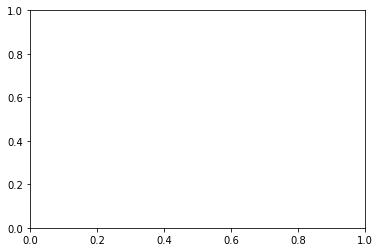

In [50]:
best_random_forest_param = random_forest_clf.best_params_
best_bagging_param = bagging_clf.best_params_
best_adaboost_param = adaboost_clf.best_params_

depth = np.arange(5, 25)
random_forest_acc, bagging_acc, adaboost_acc = [], [], []

for max_depth in depth:
    random_forest = RandomForestClassifier(max_depth=max_depth).set_params(**best_random_forest_param)
    # print(random_forest.get_params())
    random_forest_acc.append(cross_val_score(random_forest, x_train, y_train).mean())

    bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth)).set_params(
        **best_bagging_param)
    bagging_acc.append(cross_val_score(bagging, x_train, y_train).mean())

    adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth)).set_params(
        **best_adaboost_param)
    adaboost_acc.append(cross_val_score(adaboost, x_train, y_train).mean())

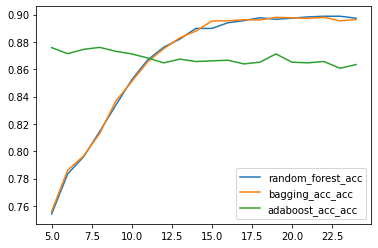

In [53]:
plt.plot(depth, random_forest_acc, label="random_forest_acc")
plt.plot(depth, bagging_acc, label="bagging_acc_acc")
plt.plot(depth, adaboost_acc, label="adaboost_acc_acc")
plt.legend()
plt.show()